In [305]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import ml_collections as mlc
import torch
from torch.autograd.functional import jacobian
import seaborn as sns

from Empirical.data import getLogRet
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train, MaskedMSELoss
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC, trainMCMCMasked
from BasicAutoEncoder.Metric import CCACorr

from Andreini_data.data import load_y

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(879, 116)


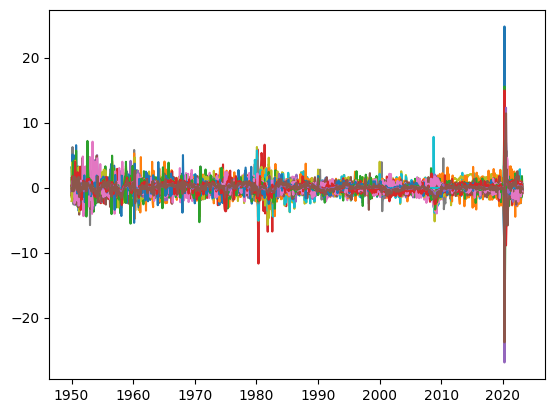

In [306]:

y, mask, index, columns= load_y(daterange=['1950-01-01', '2024-01-01'])
y[np.isnan(y)] = 0
print(y.shape)
plt.plot(index,y);

In [26]:
print(list(columns))
gdp_col = list(columns).index('GDPC1')

['PPIITM', 'PPICRM', 'PPICMM', 'CPIAUCSL', 'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAS', 'CPIULFSL', 'CUSR0000SA0L5', 'PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA', 'IPMAN', 'MCUMFN', 'TCU', 'M0684AUSM343SNBR', 'M0504AUSM343SNBR', 'GDPC1', 'AMBSL', 'TOTRESNS', 'NONBORRES', 'BUSLOANS', 'REALLN', 'NONREVSL', 'MZMSL', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST', 'FEDFUNDS', 'CP3M', 'TB3MS', 'TB6MS', 'GS1', 'GS5', 'GS10', 'AAA', 'BAA', 'TB3SMFFM', 'TB6SMFFM', 'T1YFFM', 'T5YFFM', 'T10YFFM', 'AAAFFM', 'BAAFFM', 'TWEXMMTH', 'EXSZUS', 'EXJPUS', 'EXUSUK', 'EXCAUS', 'PPIFGS', 'PPIFCG', 'USWTRADE', 'USTRADE', 'USFIRE', 'USGOVT', 'CES0600000007', 'AWOTMAN', 'CES0600000008', 'CES2000000008', 'CES3000000008', 'HOUST', 'HOUSTNE', 'HOUSTMW', 'HOUSTS', 'HOUSTW', 'PERMIT', 'PERMITNE', 'PERMITMW', 'PERMITS', 'PERMITW', 'DPCERA3M086SBEA', 'CMRMTSPL', 'RETAIL', 'ACOGNO', 'ANDENO', 'AMDMUO', 'M1SL', 'M2SL', 'M3SL', 'M2REAL', 'RPI', 'W875RX1', 'INDPRO', 'IPFPNSS', 'IPFINAL', 'I

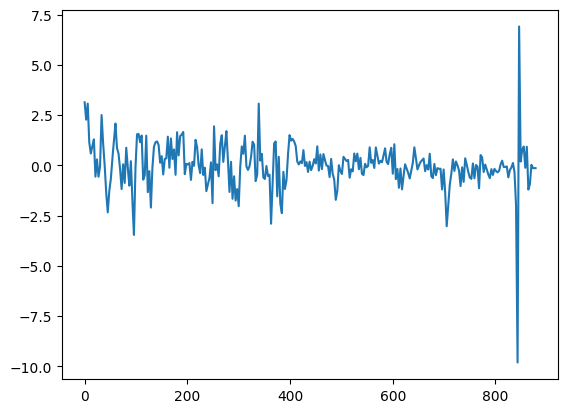

In [27]:
plt.plot(y[:,gdp_col])

(600, 116) (100, 116) (179, 116)


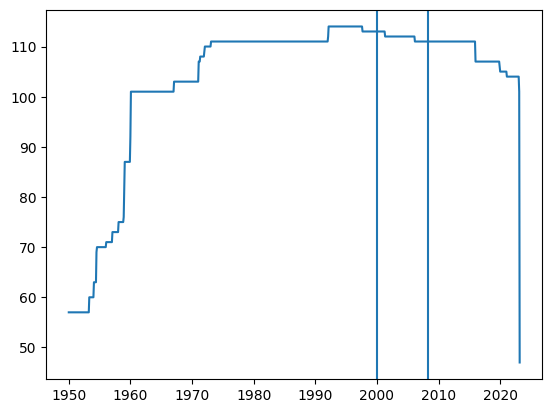

In [307]:
cfg = mlc.ConfigDict()
cfg.factor_dim = 5
cfg.obs_dim = y.shape[1]
cfg.p_factor = 2
cfg.p_eps = 0
cfg.T_train = 600
cfg.T_test = 129
cfg.T_val = 100
cfg.T = y.shape[0] #529

#Training config
cfg.batch_size = 32
cfg.lr = 0.0001
cfg.n_epoch = 10
cfg.max_iter = 25


#Create train test val
y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]

weights_train = mask[0:cfg.T_train]
weights_val = mask[cfg.T_train:cfg.T_train+cfg.T_val]
print(y_train.shape, y_val.shape, y_test.shape)


plt.plot(index,mask.sum(axis=1))
plt.axvline(x=index[cfg.T_train])
plt.axvline(x=index[cfg.T_train+cfg.T_val])

In [308]:

cfg.lr = 0.0003
cfg.max_iter = 100
cfg.n_epochs = 10
cfg.obs_dim = y_train.shape[1]
dec = Decoder(hidden_dim=[cfg.factor_dim, 40,80, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=True)
enc = Encoder(hidden_dim=[cfg.obs_dim, 80,40, cfg.factor_dim], activation=nn.Tanh(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=1)
metrics = []
train_hist = trainMCMCMasked(X_train=y_train, X_val = y_val, weights_train=weights_train, weights_val=weights_val, model=mod, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, max_iter=cfg.max_iter)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")

/Users/julianvanmeggelen/Thesis/Empirical/../BasicAutoEncoder/model.py:60: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(res[f"linear_{i}"].weight)


Number of trainable paramaters 25721
torch.Size([600, 116]) torch.Size([100, 116])
1 0.1284717431193903911939039
2 0.1917092815825813858258138
3 0.1844086952899631828996318
4 0.1773822621295326812953268
5 0.1776411839221653292216532
6 0.1753364911204890212048902
7 0.1758059153431340334313403
8 0.1718742580790268707902687
9 0.1725953095837643258376432
10 0.165480140792696179269617
11 0.167938911601116860111684
12 0.170883164594047959404795
13 0.167341334255118135511813
14 0.165457792972263547226354
15 0.169690384676581937658193
16 0.171569188958720175872017
17 0.166346457835875073587507
18 0.166551913085736728573672
19 0.169061736056679185667918
20 0.167841936412610541261056
21 0.163439870664947926494792
22 0.168008989409396510939651
23 0.165037227304358240435824
24 0.167801035862219956221995
25 0.164558263985734238573423
26 0.169326217550980435098043
27 0.161659242291199559119955
28 0.163634442577236587723658
29 0.164971802579729187972918
30 0.166613047060213606021364
31 0.161777966116

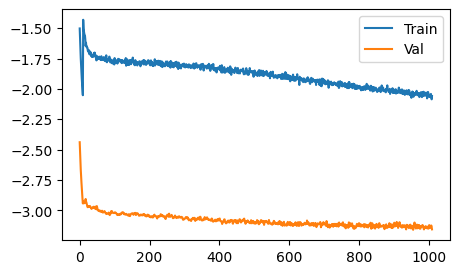

In [309]:
plot_train_hist(train_hist=train_hist, log=True)

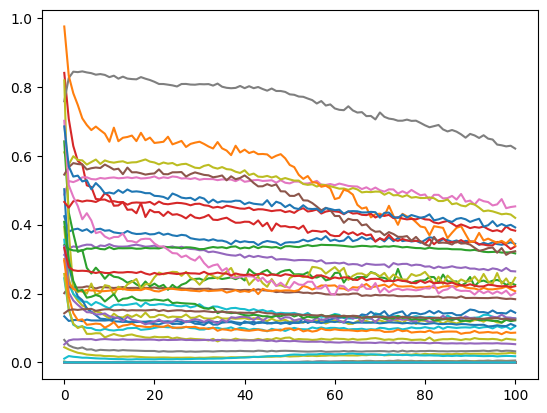

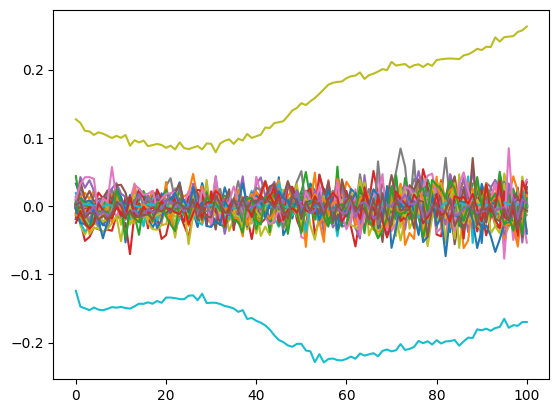

In [310]:
try:
    plt.plot([np.diag(_) for _ in errorProcess.fit_hist['cov']]);
    plt.figure()
    plt.plot(errorProcess.fit_hist['mu']);
except:
    None
try:
    plt.plot(errorProcess.fit_hist['var']);
except:
    None


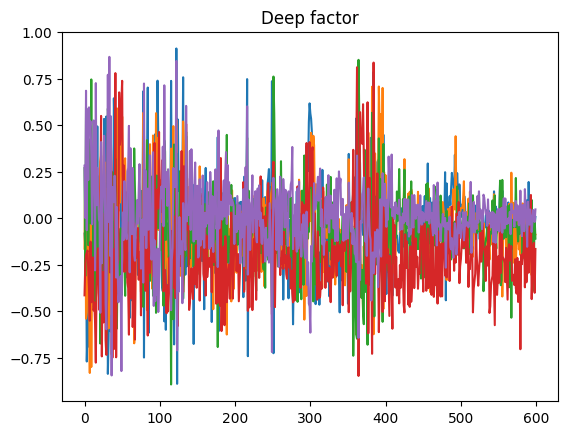

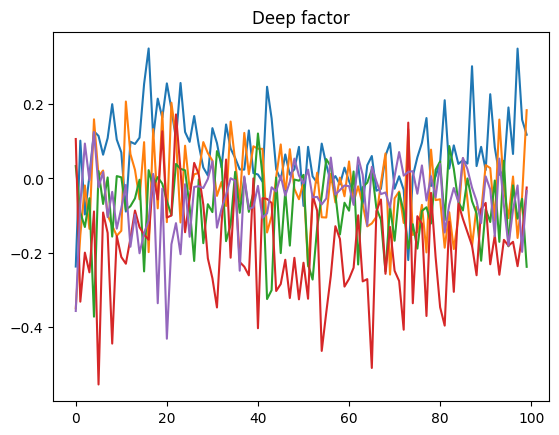

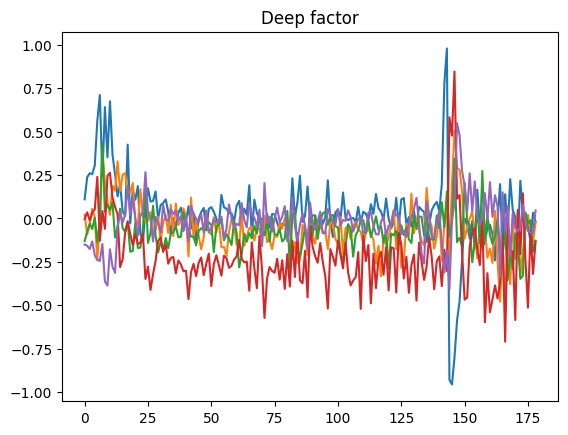

In [311]:
plot_factor_estimates(mod, y_train)
plt.figure();
plot_factor_estimates(mod, y_val)
plt.figure();
plot_factor_estimates(mod, y_test)

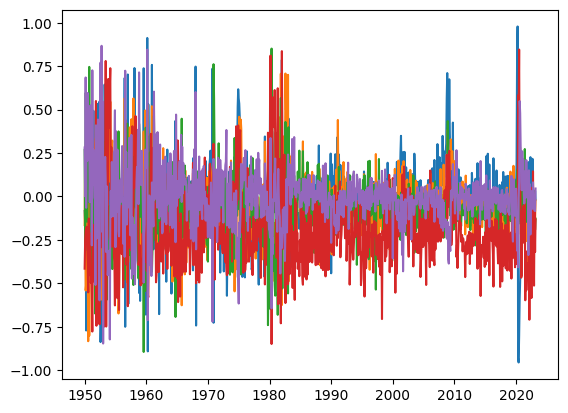

In [312]:
f_hat = mod.enc(torch.Tensor(y).float()).detach().numpy()
plt.plot(index, f_hat);

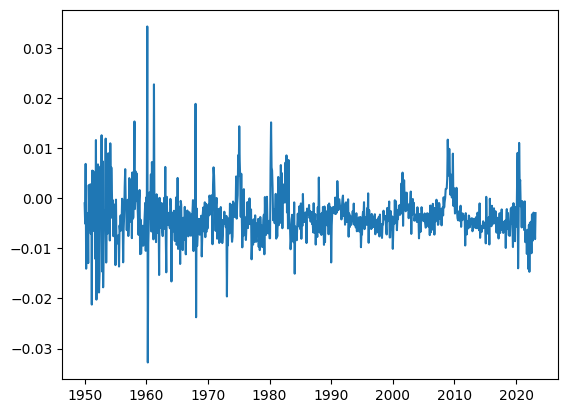

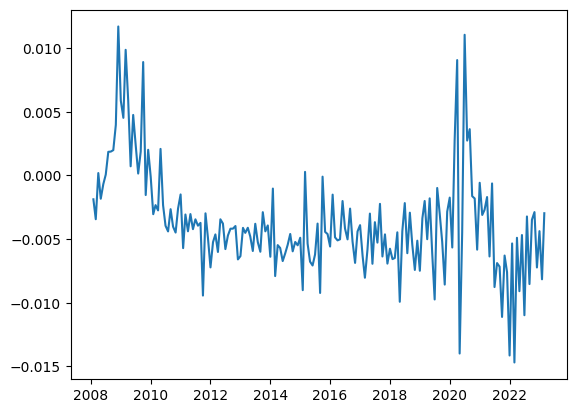

In [313]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCI(F, f):
    res = []
    sum = 0
    fn = fobreniusNorm(F)
    for k in range(f.shape[1]):
        for i in range(F.shape[1]):
            sum += f[:,k] * (F[k,i]**2)/fn
    return sum

F = mod.enc.sequential[0].weight.detach().numpy()
CI = computeCI(F, f_hat)

plt.plot(index,CI)
plt.figure()
i = np.argwhere(index > '2008').min()
plt.plot(index[i:],CI[i:])

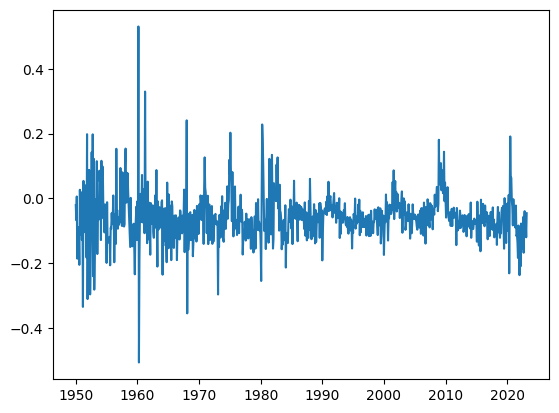

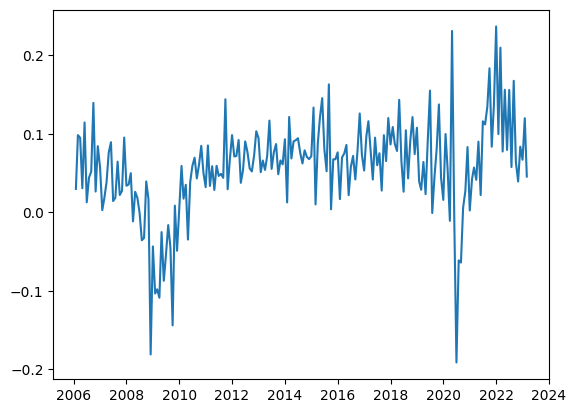

In [314]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCI(F, f):
    res = []
    for t in range(f.shape[0]):
        
        jac = jacobian(mod.dec, torch.Tensor(f[t]).float()).detach().numpy().T
        sum = 0
        fn = fobreniusNorm(jac)
        for k in range(f.shape[1]):
            for i in range(F.shape[1]):
                sum += f[t,k] * (jac[k,i]**2)/fn
        res.append(sum)
    return np.array(res)

F = mod.enc.sequential[0].weight.detach().numpy()
CI = computeCI(F, f_hat)

plt.plot(index,CI)
plt.figure()
flip = True
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],CI[i:] * (-1 if flip else 1))


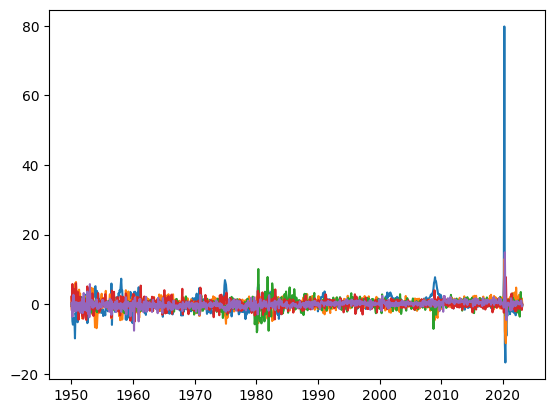

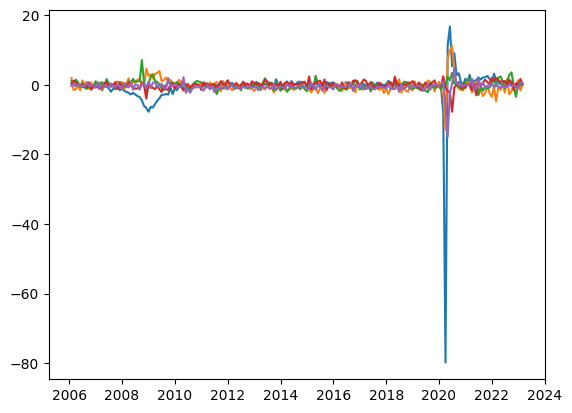

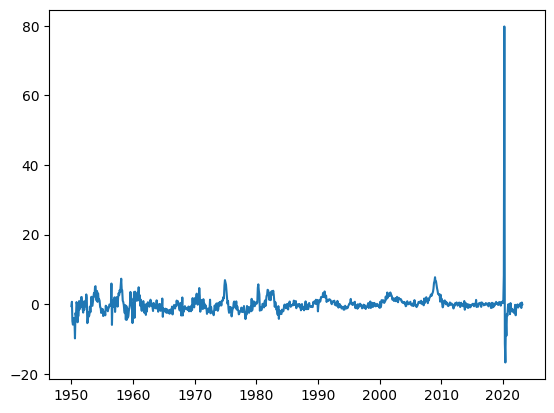

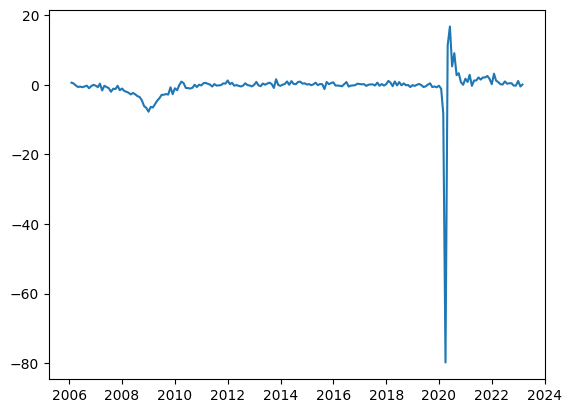

In [142]:
from sklearn.decomposition import PCA
pca = PCA(n_components=cfg.factor_dim)
f_hat_pca = pca.fit_transform(y)
plt.plot(index,f_hat_pca)
plt.figure()
flip = True
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],f_hat_pca[i:] * (-1 if flip else 1))
plt.figure()
pca = PCA(n_components=1)
f_hat_pca = pca.fit_transform(y)
plt.plot(index,f_hat_pca)
plt.figure()
flip = True
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],f_hat_pca[i:] * (-1 if flip else 1))

## Cast in statespace with EKF

In [317]:
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
varModel = VAR(np.concatenate([f_train_hat, f_val_hat]))
res = varModel.fit(maxlags=1, ic='aic')
y_hat = mod(torch.Tensor(y).float()).detach().numpy()
resid = y - y_hat
obs_cov = np.cov(resid.T)

In [319]:
np.cov((res.fittedvalues - np.concatenate([f_train_hat, f_val_hat])[1:]).T)

array([[ 4.49835315e-02, -5.24673977e-03,  1.69591888e-04,
        -3.04451924e-03, -8.55158807e-03],
       [-5.24673977e-03,  3.40312902e-02, -1.25317208e-02,
        -3.21090031e-03,  4.45731523e-03],
       [ 1.69591888e-04, -1.25317208e-02,  3.74765483e-02,
        -2.29048188e-03,  7.89989144e-03],
       [-3.04451924e-03, -3.21090031e-03, -2.29048188e-03,
         4.62661818e-02, -5.87692164e-05],
       [-8.55158807e-03,  4.45731523e-03,  7.89989144e-03,
        -5.87692164e-05,  3.02187939e-02]])

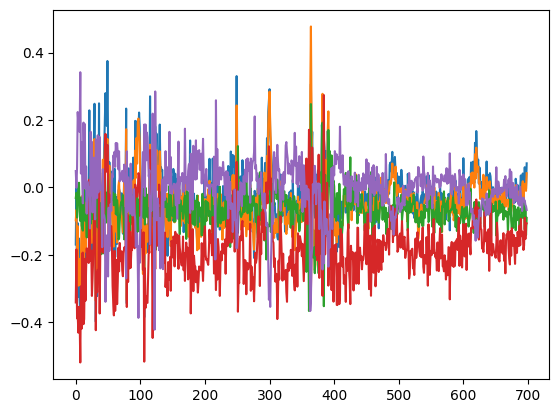

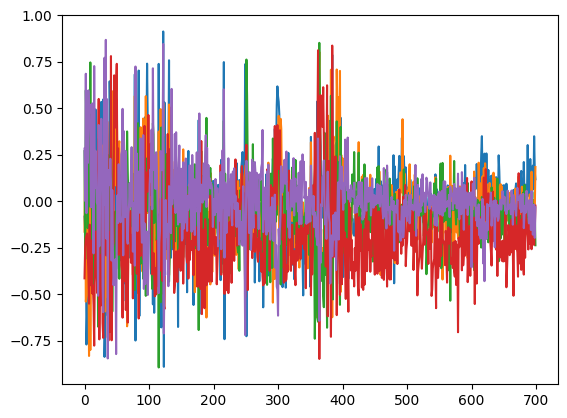

In [320]:
plt.plot(res.fittedvalues)
plt.figure()
plt.plot(np.concatenate([f_train_hat, f_val_hat]))

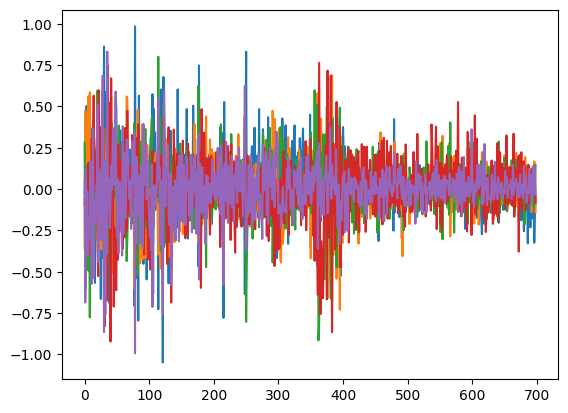

In [321]:
plt.plot(res.fittedvalues - np.concatenate([f_train_hat, f_val_hat])[1:])

<Axes: >

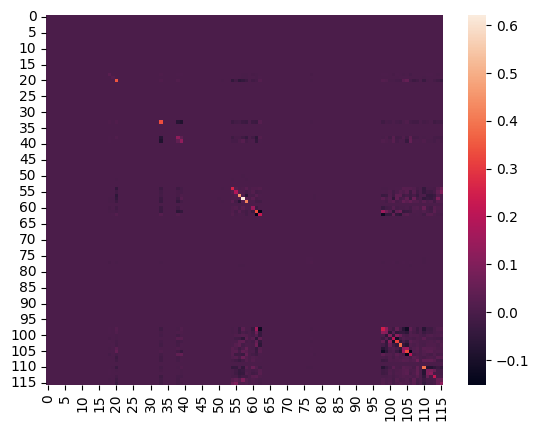

In [322]:
sns.heatmap(errorProcess.cov)

<Axes: >

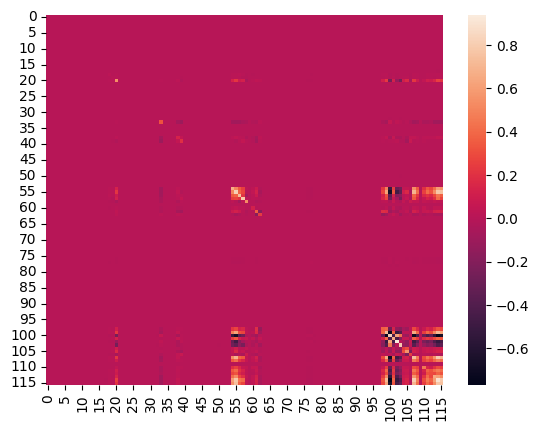

In [323]:
sns.heatmap(obs_cov)

In [363]:
from EKF.ekf import EKF, unconditionalVariance, unconditionalVariance2
y = y
Z = lambda x: mod.dec(torch.Tensor(x).float()).detach().numpy()
Z_jacobian = lambda x: jacobian(mod.dec, torch.Tensor(x).float()).detach().numpy()
H = obs_cov
T = res.params[:-1]
C = None#res.params[-1]
R = np.diag(np.ones(cfg.factor_dim))
Q = np.identity(cfg.factor_dim)#res.sigma_u
a0 = np.mean(f_train_hat, axis=0)
P0 = None#np.cov(f_train_hat.T) #None#res.sigma_u
a, P, a_filtered  = EKF(y=y,Z=Z,Z_jacobian=Z_jacobian, H=H, T=T, R=R, Q=Q, C=None, a0=a0, P0=P0)

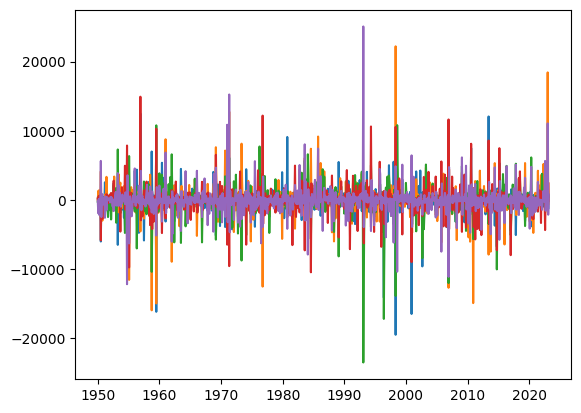

In [364]:
plt.plot(index,a_filtered[:-1])

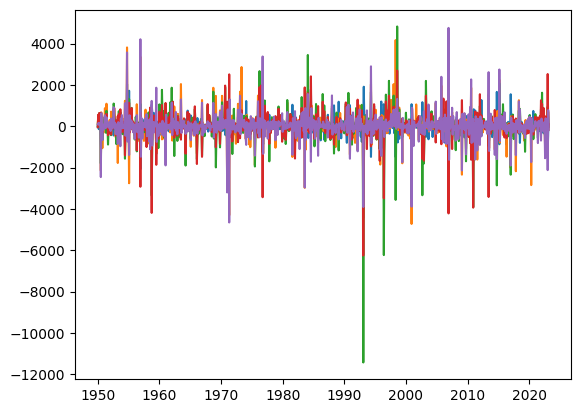

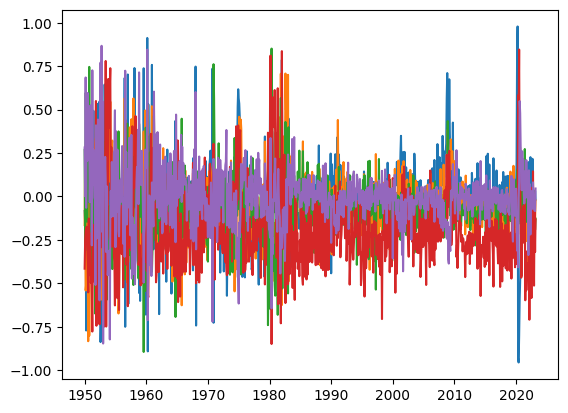

In [365]:
plt.plot(index,a)
plt.figure()
plt.plot(index,f_hat)

In [256]:
a[:]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-3.94463294e+03, -2.65588584e+02,  3.39222810e+01,
        -4.45262137e+01, -6.20167537e+02],
       [-3.61560403e+02, -8.76045281e+00, -2.09439314e+00,
        -5.66605293e+00, -4.16422913e+01],
       ...,
       [-2.72869745e+02, -7.71473820e+00, -1.09248605e+00,
        -6.15069847e+00, -3.34249103e+01],
       [-2.79691649e+02, -7.53633354e+00, -1.20882671e+00,
        -6.38357783e+00, -3.42662172e+01],
       [-2.87015925e+02, -7.92916600e+00, -1.23555461e+00,
        -6.63955117e+00, -3.50355193e+01]])

In [190]:
res.sigma_u

array([[ 6.30185574,  4.17401048,  5.12210284,  4.03426597,  3.45850929],
       [ 4.17401048, 10.24410662,  6.82764073,  4.7609111 ,  5.24763828],
       [ 5.12210284,  6.82764073, 12.24474624,  6.3189485 ,  6.16086533],
       [ 4.03426597,  4.7609111 ,  6.3189485 , 15.63552312,  9.61933475],
       [ 3.45850929,  5.24763828,  6.16086533,  9.61933475, 14.55233607]])

In [196]:
res.mean()

array([5.87870346, 6.35967424, 6.35338814, 8.31293004, 8.66123531])

In [188]:
np.cov(f_train_hat.T).round(2)

array([[ 9.68,  7.64,  9.13, 11.03,  8.12],
       [ 7.64, 14.93, 11.67, 12.18, 10.34],
       [ 9.13, 11.67, 18.99, 15.24, 12.23],
       [11.03, 12.18, 15.24, 33.89, 21.28],
       [ 8.12, 10.34, 12.23, 21.28, 23.3 ]])

In [182]:
np.linalg.inv(np.identity(T.shape[0]**2)- np.kron(T,T)).shape

(25, 25)

In [226]:
print(unconditionalVariance(T,(res.sigma_u)).round(2))

[[-1091.19   144.89   -20.45    39.93   126.36]
 [  144.89    23.37     4.34    14.29    25.29]
 [  -20.45     4.34    12.95     4.63     2.84]
 [   39.93    14.29     4.63    21.9     21.34]
 [  126.36    25.29     2.84    21.34    43.24]]


In [154]:
res.sigma_u.shape

(5, 5)

In [152]:
res.params[-1]


array([-0.06869725, -0.06222471, -0.02176665, -0.14495933, -0.26186914])

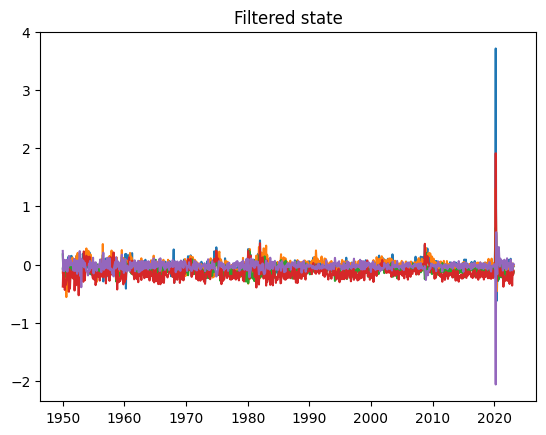

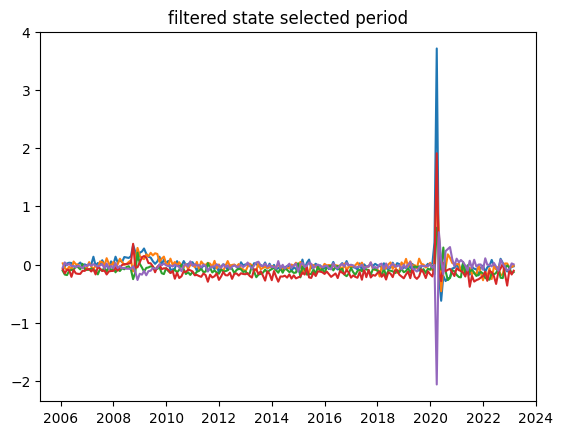

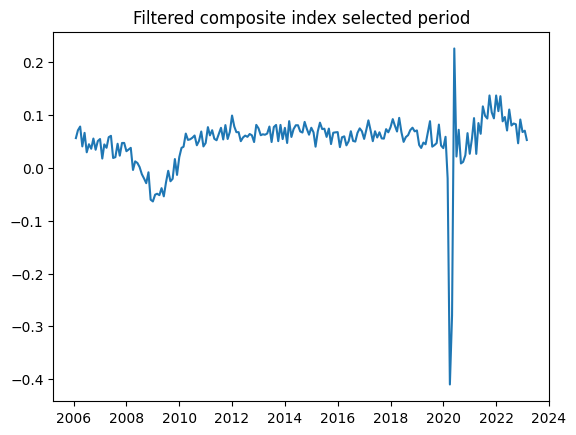

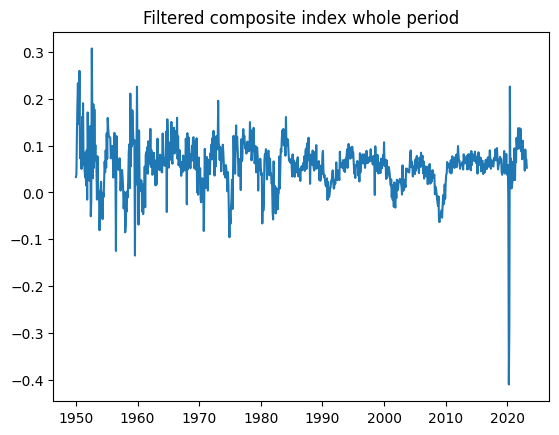

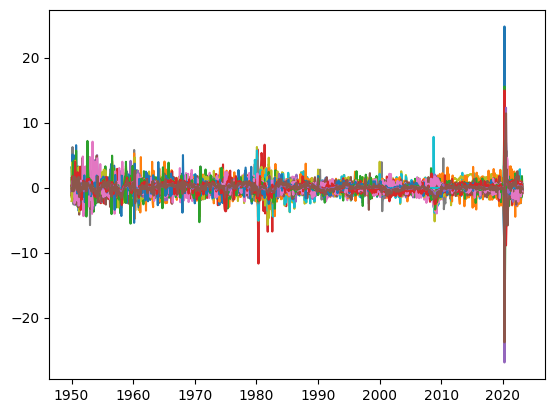

In [350]:
from filterpy.kalman import ExtendedKalmanFilter as ExtendedKalmanFilter
dim_x = cfg.factor_dim
dim_z = cfg.obs_dim
ekf = ExtendedKalmanFilter(dim_x, dim_z)
ekf.R = np.diag(np.diag(np.where(errorProcess.cov < 0, 0.0, errorProcess.cov)))
#ekf.R = obs_cov

#ekf.Q = res.sigma_u
ekf.F = res.params[:-1]
#ekf.P = res.sigma_u
ekf.x = f_train_hat[0]
decoder = mod.dec
Hx = lambda state: decoder(torch.Tensor(state).float()).detach().numpy()
HJacobian = lambda state: jacobian(decoder,torch.Tensor(state).float()).detach().numpy()
xs = []
zs = []
for i in range(y.shape[0]):
    z = y[i,:]
    ekf.update(z, HJacobian, Hx)
    xs.append(ekf.x)
    ekf.predict()
    zs.append(ekf.z)
plt.plot(index, np.stack(xs));
plt.title('Filtered state')
plt.figure()
i = np.argwhere((index > '2006') & (index < '2012')).min()
plt.plot(index[i:], np.stack(xs)[i:]);
plt.title('filtered state selected period')
plt.figure()
flip = True
CI_filtered = computeCI(F, np.stack(xs))
plt.plot(index[i:],CI_filtered[i:] * (-1 if flip else 1))
plt.title('Filtered composite index selected period')
plt.figure()
plt.plot(index, CI_filtered * (-1 if flip else 1))
plt.title('Filtered composite index whole period')
plt.figure()
plt.plot(index, np.stack(zs));


Text(0.5, 1.0, 'Filtered composite index selected period')

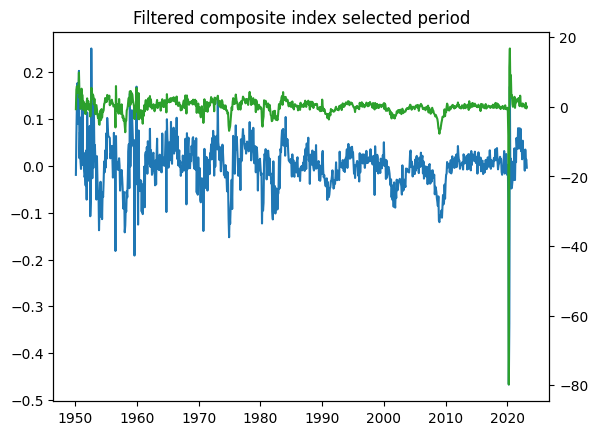

In [370]:
i = np.argwhere((index > '1950') & (index < '2012')).min()
ours = CI_filtered[i:]
ours= ours - ours.mean()
#ours = (ours-ours.max())/(ours.max()-ours.min())
pca  = f_hat_pca[i:]
#pca = (pca-pca.max())/(pca.max()-pca.min())
pca = pca-pca.mean()
plt.plot(index[i:],ours * (-1 if flip else 1))

ax = plt.twinx()
ax.plot(index[i:],pca * (-1 if flip else 1), c='C2')
plt.title('Filtered composite index selected period')